# Предсказание следующего символа (генерация поэзии)

Задача: сгенерировать стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

## Импорт инструментария

In [ ]:
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))

cuda device is available


## Загрузка данных

In [ ]:
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])

--2024-11-09 20:04:35--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2024-11-09 20:04:35 (10.3 MB/s) - ‘onegin.txt’ saved [262521/262521]



## Построение словаря и предобработка текста

Требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")

text_encoded = [token_to_idx[x] for x in text]

Seems fine!


__Задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Полезные ссылки:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Реализуем функцию, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`.

In [ ]:
batch_size = 128
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

Пример батча:

In [6]:
print(next(generate_chunk()).shape)
next(generate_chunk())

(512, 101)


array([[83,  0, 49, ..., 45, 12,  0],
       [83, 56, 75, ..., 56, 45,  5],
       [83,  1, 47, ..., 57, 64,  1],
       ...,
       [83, 58, 50, ..., 59, 75,  1],
       [83, 47, 56, ..., 59, 58, 14],
       [83,  1, 64, ..., 58, 73, 50]])

## Model

In [101]:
class RNNModel(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, dropout
        ):
        super(RNNModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(
            hidden_size, hidden_size,
            num_layers=n_layers, batch_first=True,
            )
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h0):
        le = self.embed(x)
        out, hn = self.rnn(le, h0)
        out = self.linear(out)
        return out, hn

    def init_h0(self, batch_size):
        return torch.zeros(
            self.n_layers, batch_size, self.hidden_size
            ).to(device)

In [112]:
# Модель с Attention
class AttentionRNN(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_dim, num_layers, dropout=0.0
        ):
        super(AttentionRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(
            embedding_dim, hidden_dim,
            num_layers=num_layers, dropout=dropout, batch_first=True,
            )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def attention(self, rnn_out):
        # Применяем механизм внимания
        attn_weights = torch.bmm(rnn_out, rnn_out.transpose(1, 2))  # Вычисляем веса внимания
        attn_weights = torch.softmax(attn_weights, dim=-1)  # Применяем softmax

        context = torch.bmm(attn_weights, rnn_out)  # Получаем контекстный вектор
        return context

    def forward(self, x, h0):
        embedded = self.embedding(x)  # Встраивание
        rnn_out, hn = self.rnn(embedded, h0)  # Пропускаем через RNN
        context = self.attention(rnn_out)  # Применяем внимание
        out = self.fc(context)  # Полносвязный слой
        return out, hn

    def init_h0(self, batch_size):
        return torch.zeros(
            self.num_layers, batch_size, self.hidden_dim
            ).to(device)

## Training

In [107]:
batch_size = 128
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

In [15]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [108]:
# Параметры
vocab_size = len(token_to_idx)  # Размер словаря
hidden_dim = 512 # Размер скрытого состояния
embedding_dim = 512 # Размер эмбеддингов
n_layers = 2
dropout = 0.0
factor = 0.5
patience = 50

# Создание модели
model = RNNModel(
    vocab_size, embedding_dim, hidden_dim, n_layers, dropout=dropout
    ).to(device)

# model = AttentionRNN(
#     vocab_size, embedding_dim, hidden_dim, n_layers, dropout=dropout
#     ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=factor, patience=patience
    )
# Инициализация весов
model.apply(init_weights)

RNNModel(
  (embed): Embedding(84, 512)
  (rnn): GRU(512, 512, num_layers=2, batch_first=True)
  (linear): Linear(in_features=512, out_features=84, bias=True)
)

In [109]:
num_epochs = 2000  # Количество эпох
rep_freq = 100      # Частота отчётов
loss_history = []

for epoch in range(1, num_epochs + 1):
    model.train()  # Переводим модель в режим обучения
    hidden = model.init_h0(batch_size)  # Инициализация скрытого состояния
    total_loss = 0

    for batch in generate_chunk():
        inputs = torch.tensor(batch[:, :-1]).to(device) # Индексы символов
        targets = torch.tensor(batch[:, 1:]).to(device) # Цели
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs, hidden = model(inputs, hidden)  # Прямой проход
        # Изменяем форму выходов для потерь
        outputs = outputs.view(-1, vocab_size)  # (batch_size * sequence_length, output_size)
        targets = targets.view(-1)  # (batch_size * sequence_length,)
        loss = criterion(outputs, targets)  # Вычисляем потерю
        loss.backward()  # Обратный проход
        optimizer.step()  # Обновляем параметры

        total_loss += loss.item()

    loss_history.append(total_loss)  # Сохраняем общую потерю
    lr_scheduler.step(total_loss)  # Передаем общую потерю в lr_scheduler

    if epoch % rep_freq == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {total_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]}')

Epoch [1/2000], Loss: 4.4524, LR: 0.01
Epoch [100/2000], Loss: 1.9516, LR: 0.01
Epoch [200/2000], Loss: 1.4919, LR: 0.01
Epoch [300/2000], Loss: 1.1843, LR: 0.01
Epoch [400/2000], Loss: 1.1101, LR: 0.01
Epoch [500/2000], Loss: 0.7751, LR: 0.01
Epoch [600/2000], Loss: 0.4442, LR: 0.005
Epoch [700/2000], Loss: 0.3396, LR: 0.005
Epoch [800/2000], Loss: 0.3224, LR: 0.005
Epoch [900/2000], Loss: 0.2309, LR: 0.0025
Epoch [1000/2000], Loss: 0.2184, LR: 0.000625
Epoch [1100/2000], Loss: 0.2074, LR: 0.0003125
Epoch [1200/2000], Loss: 0.2087, LR: 7.8125e-05
Epoch [1300/2000], Loss: 0.3562, LR: 1.953125e-05
Epoch [1400/2000], Loss: 0.2154, LR: 4.8828125e-06
Epoch [1500/2000], Loss: 0.2057, LR: 1.220703125e-06
Epoch [1600/2000], Loss: 0.2127, LR: 6.103515625e-07
Epoch [1700/2000], Loss: 0.2031, LR: 3.0517578125e-07
Epoch [1800/2000], Loss: 0.2286, LR: 7.62939453125e-08
Epoch [1900/2000], Loss: 0.2189, LR: 1.9073486328125e-08
Epoch [2000/2000], Loss: 0.2199, LR: 1.9073486328125e-08


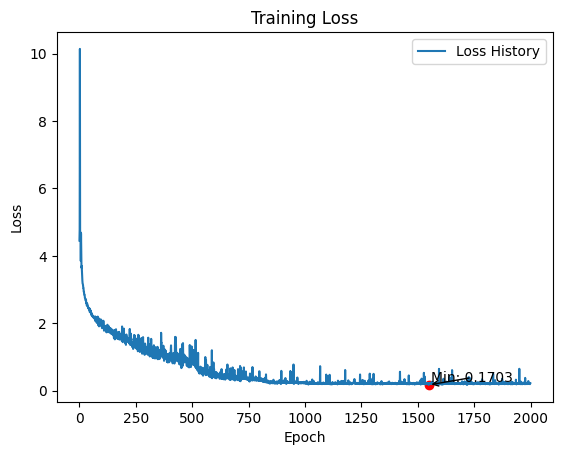

In [110]:
# Построение графика
plt.plot(loss_history, label='Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Находим минимум
min_loss = min(loss_history)
min_index = loss_history.index(min_loss)

# Отображаем минимум на графике
plt.scatter(min_index, min_loss, color='red')  # Отметка минимума
plt.annotate(f'Min: {min_loss:.4f}', xy=(min_index, min_loss),
             xytext=(min_index + 10, min_loss + 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.legend()
plt.show()

## Evaluation

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [20]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # Initialize hidden state
    hidden = char_rnn.init_h0(batch_size=1)

    # Feed the seed phrase into the model
    with torch.no_grad():
        output, hidden = char_rnn(x_sequence, hidden)

    # Start generating characters
    generated_sequence = x_sequence[0].tolist()  # Start with the input sequence

    for _ in range(max_length - len(generated_sequence)):
        # Get the last character's output
        last_output = output[:, -1, :]  # Shape: (1, vocab_size)

        # Apply temperature
        last_output = last_output / temperature

        # Sample from the output distribution
        probabilities = nn.functional.softmax(last_output, dim=-1).cpu().numpy().flatten()
        next_char_idx = np.random.choice(len(probabilities), p=probabilities)

        # Append the predicted character to the generated sequence
        generated_sequence.append(next_char_idx)

        # Prepare the input for the next step
        next_input = torch.tensor([[next_char_idx]], dtype=torch.int64).to(device)

        # Feed the next input into the model
        with torch.no_grad():
            output, hidden = char_rnn(next_input, hidden)

    # Convert indices back to characters
    return ''.join([tokens[ix] for ix in generated_sequence])

Пример текста сгенерированного обученной моделью ниже. Используемая модель очень проста и потому в тексте много несуществующих слов.

In [111]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=1000, temperature=0.8))

<sos> мой дядя самых честных правилахой,
перед камином стол настал от упобыла светла,
и неотворя на силах я;
мне должно после долгой речи
и погулять и отдохнуть:
докончу после как-нибудь.



глава четвертая


vii

чем меньше женщину мы любим,
тем легче нравимся мы ей
и тем ее вернее губим
средь обольстительных оставленный,
в постеле с ним подавал.
потри порок он строгие занимал:
то вздох нескромный в чай неслась
идела в сладкий долго в окна.



xxv

с смеркалось головои,
что наградушная лета.
татьяна ей странен.
с каким живым очарована
с очами бродит, и думает
и лица петушков
и ольге петушков,
к татьяне ленский; харликову,
невесту переспелых лет,
берет тамбовский мой поэт,
умчал буянов пустякову,
и в залу высыпали все,
и бал блестит во всей красе.



l

писать и правда ль? я счастлив.
но поздной теснит и льются. изговой
не зная, как его понять. но вас,
но легче летучиет,
с волну, в тишине сует,
в глуши мудрец гремя встает;
все вышли и глас именем ответа.
другой настал: всё нет, кал на 